# <font color="#F48E16">Formación en XAI de Deep Learning: Explicabilidad Genérica</font>

Material generado por <a href="https://www.linkedin.com/in/christian-oliva-moya-ingeniero/">Christian Oliva</a>. Cualquier duda, sugerencia o errata, no duden en contactar.

**Versión 1.0** - 29 de agosto de 2025

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kagglehub
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## <font color="#F48E16">Datos</font>

En este notebook se muestra la implementación manual de los diferentes algoritmos de explicabilidad genérica vistos durante el curso, que son los siguientes:

- Importancia por permutación

- Relevancia por oclusión

- SHAP

- LIME

Para ello, se van a utilizar diferentes modelos sencillos de SKLearn sobre un dataset de riesgo financiero para la aprobación de préstamos: **Loan Approval Classification Dataset**

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

<hr>

En el notebook se desarrolla el código por completo según una fase sencilla de preprocesamiento de los datos, el entrenamiento de algunos modelos y la explicabilidad utilizando los diferentes algoritmos.

### Descarga de datos de Kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

100%|██████████| 751k/751k [00:00<00:00, 64.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/taweilo/loan-approval-classification-data/versions/1


### Primer vistazo de los datos

In [3]:
data = pd.read_csv(path + "/loan_data.csv")
data

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
data.isna().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


### Preprocesamiento

#### Person Age

<Axes: >

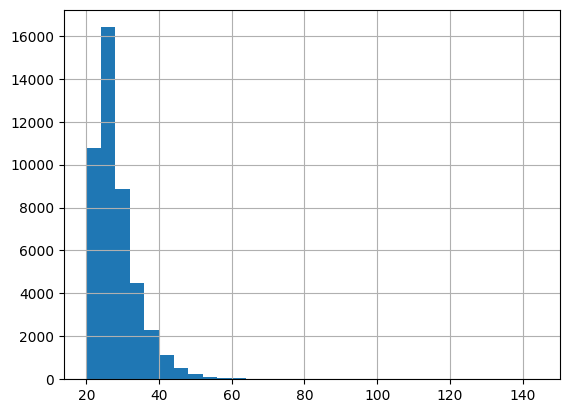

In [6]:
variable = data["person_age"]
variable.hist(bins=31)

<Axes: >

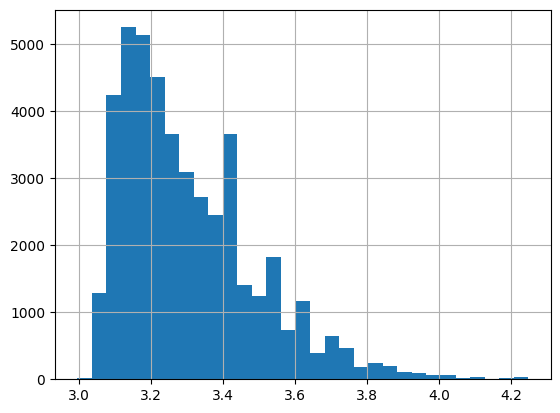

In [7]:
variable = np.clip(variable, 0, 70)
variable = np.log(variable)
variable.hist(bins=31)

#### Person Income

<Axes: >

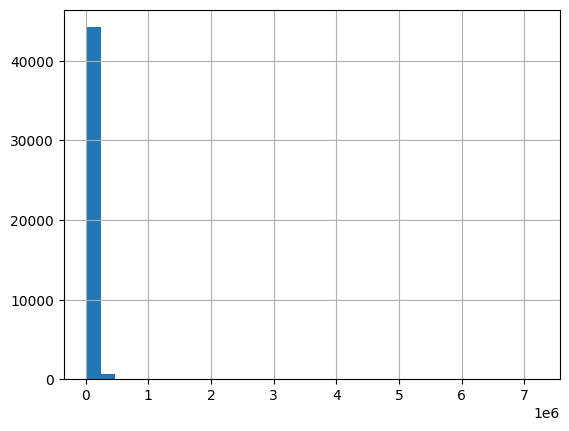

In [8]:
variable = data["person_income"]
variable.hist(bins=31)

<Axes: >

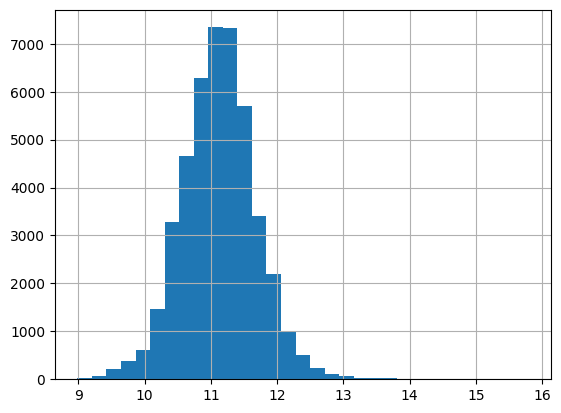

In [9]:
np.log(variable).hist(bins=31)

#### Person Emp Exp (años de experiencia)

<Axes: >

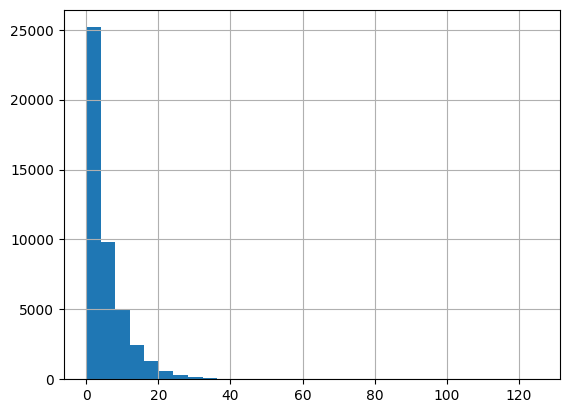

In [10]:
variable = data["person_emp_exp"]
variable.hist(bins=31)

<Axes: >

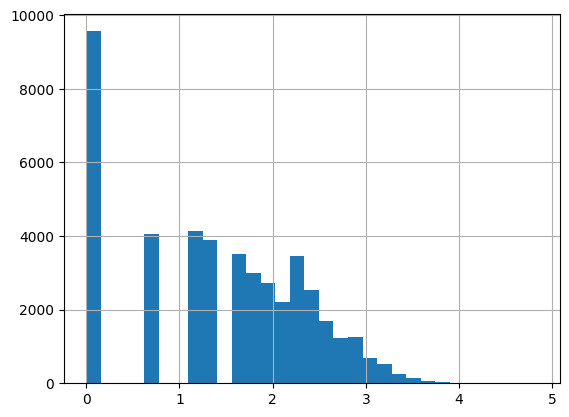

In [11]:
variable = np.log(variable+1) # Sumo 1 para evitar -inf
variable.hist(bins=31)

#### Person Home Ownership (situación de propiedad de la vivienda)

Los únicos valores posibles son RENT (alquiler), OWN (propiedad), MORTGAGE (hipoteca) y OTHER (otro).

In [12]:
variable = data["person_home_ownership"]
variable.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [13]:
pd.get_dummies(variable, prefix="person_home_ownership_")

,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT
0,False,False,False,True
1,False,False,True,False
2,True,False,False,False
3,False,False,False,True
4,False,False,False,True
...,...,...,...,...
44995,False,False,False,True
44996,False,False,False,True
44997,False,False,False,True
44998,False,False,False,True


#### Loan Amnt (valor del préstamo)

<Axes: >

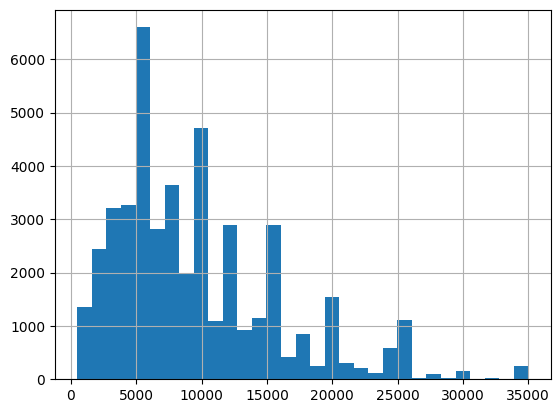

In [14]:
variable = data["loan_amnt"]
variable.hist(bins=31)

<Axes: >

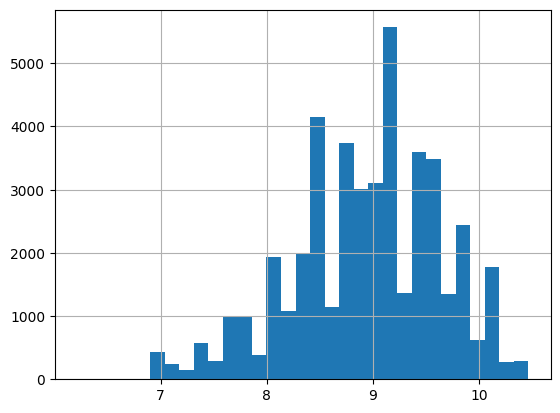

In [15]:
variable = np.log(variable)
variable.hist(bins=31)

#### Loan Intent (finalidad del préstamo)

Tiene un conjunto finito de valores: PERSONAL (personal), EDUCATION (educación), VENTURE (médico), HOMEIMPROVEMENT (mejora del hogar) y DEBTCONSOLIDATION (consolidación de deudas).

In [16]:
variable = data["loan_intent"]
variable.unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [17]:
pd.get_dummies(variable, prefix="loan_intent_")

,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
0,False,False,False,False,True,False
1,False,True,False,False,False,False
2,False,False,False,True,False,False
3,False,False,False,True,False,False
4,False,False,False,True,False,False
...,...,...,...,...,...,...
44995,False,False,False,True,False,False
44996,False,False,True,False,False,False
44997,True,False,False,False,False,False
44998,False,True,False,False,False,False


#### Loan Int Rate (tipo de interés)

<Axes: >

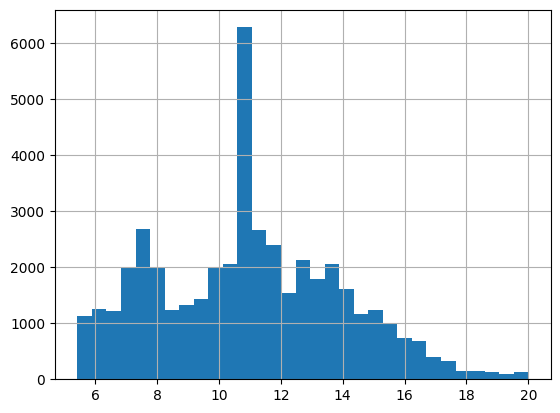

In [18]:
variable = data["loan_int_rate"]
variable.hist(bins=31)

#### Loan Percent Income (pct del préstamo respecto a los ingresos anuales)

<Axes: >

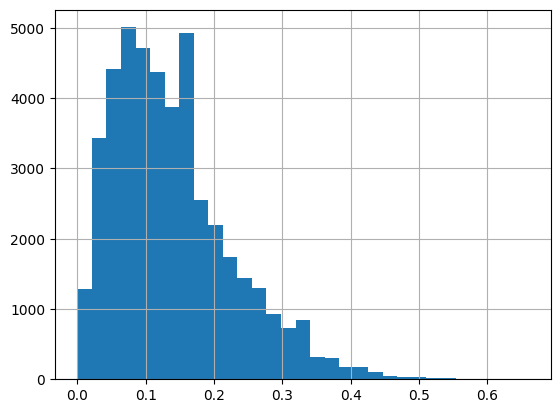

In [19]:
variable = data["loan_percent_income"]
variable.hist(bins=31)

<Axes: >

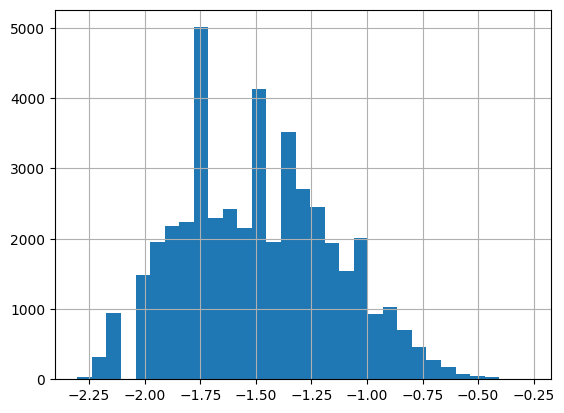

In [20]:
variable = np.log(variable+1e-1)
variable.hist(bins=31)

#### Cb Person Cred Hist Length (duración del crédito)

<Axes: >

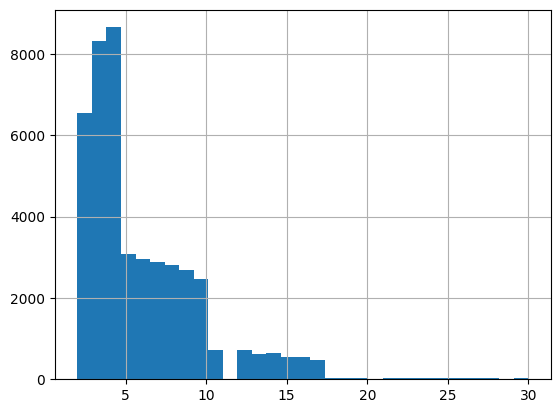

In [21]:
variable = data["cb_person_cred_hist_length"]
variable.hist(bins=31)

<Axes: >

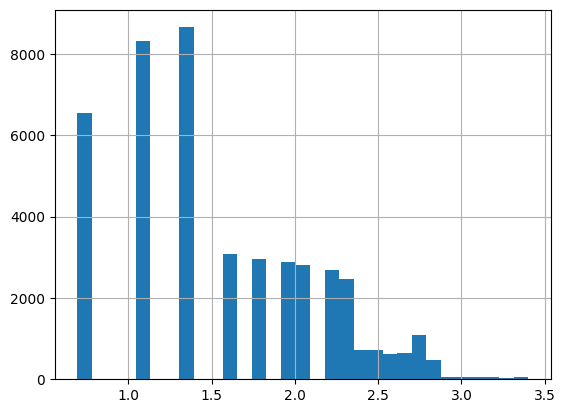

In [22]:
variable = np.log(variable)
variable.hist(bins=31)

#### Credit Score

<Axes: >

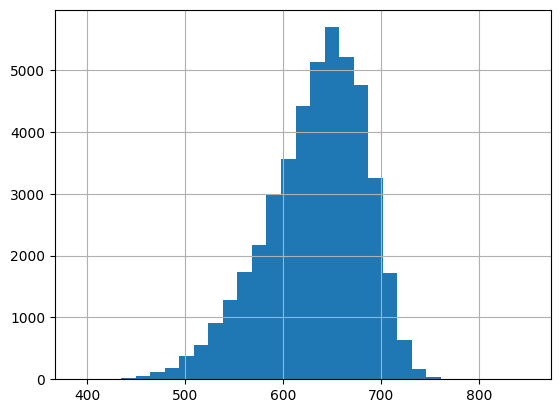

In [23]:
variable = data["credit_score"]
variable.hist(bins=31)

#### Previous Loan Defaults on File (impagos anteriores)

In [24]:
variable = data["previous_loan_defaults_on_file"]
variable.unique()

array(['No', 'Yes'], dtype=object)

In [25]:
variable.replace({"No": 0, "Yes": 1})

/tmp/ipython-input-1026067519.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  variable.replace({"No": 0, "Yes": 1})


,previous_loan_defaults_on_file
0,0
1,1
2,0
3,0
4,0
...,...
44995,0
44996,0
44997,0
44998,0


#### TODO JUNTO

In [26]:
data["person_age"] = np.log(np.clip(data["person_age"], 0, 70))
data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
data["person_income"] = np.log(data["person_income"])
data["person_emp_exp"] = np.log(data["person_emp_exp"]+1)
data = pd.concat((data, pd.get_dummies(data["person_home_ownership"], prefix="person_home_ownership_")), axis=1)
data = data.drop(columns=["person_home_ownership"])
data["loan_amnt"] = np.log(data["loan_amnt"])
data = pd.concat((data, pd.get_dummies(data["loan_intent"], prefix="loan_intent_")), axis=1)
data = data.drop(columns=["loan_intent"])
data["loan_percent_income"] = np.log(data["loan_percent_income"]+0.1)
data["cb_person_cred_hist_length"] = np.log(data["cb_person_cred_hist_length"])
data["previous_loan_defaults_on_file"] = data["previous_loan_defaults_on_file"].replace({"No": 0, "Yes": 1})

/tmp/ipython-input-2525706371.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
/tmp/ipython-input-2525706371.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
/tmp/ipython-input-2525706371.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old 

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       45000 non-null  float64
 1   person_gender                    45000 non-null  int64  
 2   person_education                 45000 non-null  int64  
 3   person_income                    45000 non-null  float64
 4   person_emp_exp                   45000 non-null  float64
 5   loan_amnt                        45000 non-null  float64
 6   loan_int_rate                    45000 non-null  float64
 7   loan_percent_income              45000 non-null  float64
 8   cb_person_cred_hist_length       45000 non-null  float64
 9   credit_score                     45000 non-null  int64  
 10  previous_loan_defaults_on_file   45000 non-null  int64  
 11  loan_status                      45000 non-null  int64  
 12  person_home_owners

### Separación en TRAIN-TEST y normalización

In [28]:
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

In [29]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
means = X_train_raw.mean()
stds = X_train_raw.std()
X_train = (X_train_raw-means) / stds
X_test = (X_test_raw-means) / stds

In [31]:
X_train.describe()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
count,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,...,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04
mean,-2.044587e-15,-8.092292e-18,3.088887e-17,-1.318254e-15,-4.144833e-18,-1.299504e-15,1.139681e-15,1.340163e-16,-2.197748e-16,-6.506400e-16,...,-8.990339e-17,1.973730e-19,7.065953e-17,1.028313e-16,6.710681e-17,1.302662e-17,2.171103e-17,5.279727e-18,-2.072416e-17,6.118562e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.634282e+00,-1.106582e+00,-1.288573e+00,-3.820060e+00,-1.480771e+00,-3.838885e+00,-1.867012e+00,-2.348392e+00,-1.469157e+00,-4.827681e+00,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
25%,-6.664523e-01,-1.106582e+00,-1.288573e+00,-6.451277e-01,-7.631502e-01,-5.969609e-01,-8.101133e-01,-8.153795e-01,-7.966108e-01,-6.094639e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
50%,-2.415560e-01,9.036589e-01,-3.606891e-01,-1.742892e-02,1.854926e-01,6.478053e-02,2.628404e-03,-7.049805e-02,-3.194316e-01,1.466317e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
75%,5.180761e-01,9.036589e-01,5.671948e-01,6.186931e-01,7.940326e-01,6.646859e-01,6.782409e-01,7.276121e-01,8.302939e-01,7.435493e-01,...,1.197169e+00,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
max,5.015846e+00,9.036589e-01,2.422962e+00,8.343544e+00,3.526269e+00,2.142782e+00,3.009438e+00,3.394679e+00,3.022695e+00,4.325055e+00,...,1.197169e+00,1.904275e+01,3.759257e+00,9.603814e-01,2.298147e+00,1.969081e+00,2.905366e+00,2.068821e+00,2.229352e+00,2.186582e+00


In [32]:
columnas = X_train_raw.columns
columnas

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership__MORTGAGE',
       'person_home_ownership__OTHER', 'person_home_ownership__OWN',
       'person_home_ownership__RENT', 'loan_intent__DEBTCONSOLIDATION',
       'loan_intent__EDUCATION', 'loan_intent__HOMEIMPROVEMENT',
       'loan_intent__MEDICAL', 'loan_intent__PERSONAL',
       'loan_intent__VENTURE'],
      dtype='object')

In [33]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [34]:
X_train.shape, y_train.shape

((36000, 21), (36000,))

## <font color="#F48E16">Modelos</font>

### Regresión Logística (modelo lineal)

In [35]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
pred = rl.predict(X_test)
rl.score(X_test, y_test)

0.8955555555555555

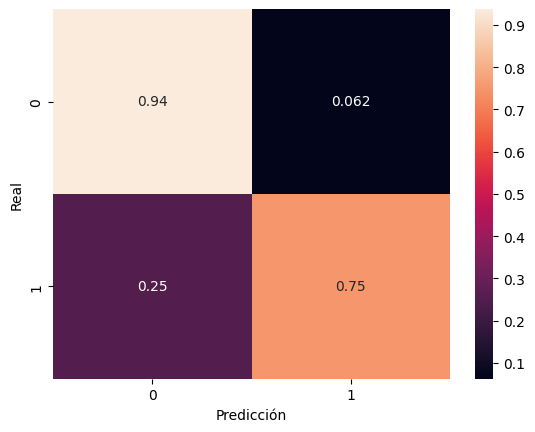

In [36]:
sns.heatmap(confusion_matrix(y_test, pred, normalize="true"), annot=True)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel().tolist()

print(" > ACCURACY:", (tp+tn)/(tp+tn+fp+fn))
print(" > PRECISION:", tp/(tp+fp))
print(" > RECALL:", tp/(tp+fn))

 > ACCURACY: 0.8955555555555555
 > PRECISION: 0.7754891864057673
 > RECALL: 0.7492537313432835


### SVM

In [38]:
svc = SVC(kernel="rbf", C=1.0, gamma="scale", max_iter=2000, probability=True)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
svc.score(X_test, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.8704444444444445

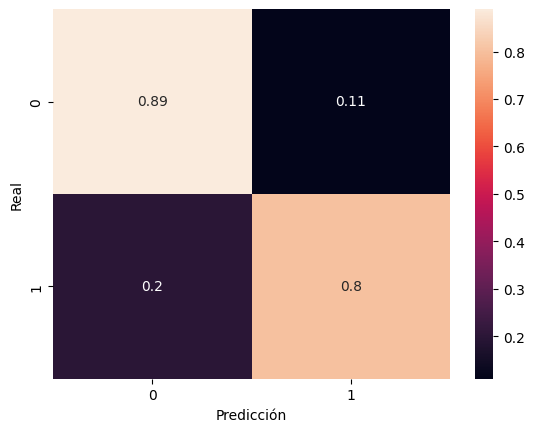

In [39]:
sns.heatmap(confusion_matrix(y_test, pred, normalize="true"), annot=True)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel().tolist()

print(" > ACCURACY:", (tp+tn)/(tp+tn+fp+fn))
print(" > PRECISION:", tp/(tp+fp))
print(" > RECALL:", tp/(tp+fn))

 > ACCURACY: 0.8704444444444445
 > PRECISION: 0.6767169179229481
 > RECALL: 0.8039800995024876


### MLP

In [41]:
red = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000)
red.fit(X_train, y_train)
pred = red.predict(X_test)
red.score(X_test, y_test)

0.9135555555555556

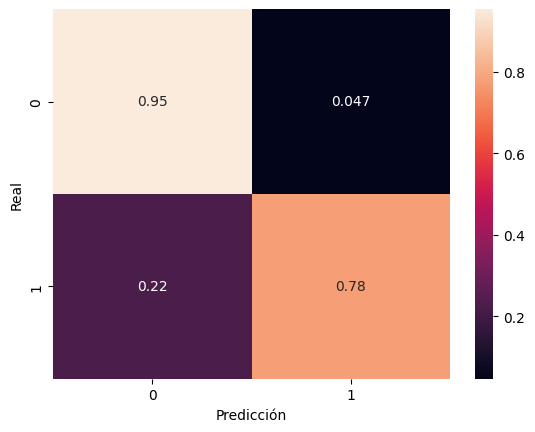

In [42]:
sns.heatmap(confusion_matrix(y_test, pred, normalize="true"), annot=True)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel().tolist()

print(" > ACCURACY:", (tp+tn)/(tp+tn+fp+fn))
print(" > PRECISION:", tp/(tp+fp))
print(" > RECALL:", tp/(tp+fn))

 > ACCURACY: 0.9135555555555556
 > PRECISION: 0.8266171792152704
 > RECALL: 0.7756218905472637


## <font color="#F48E16">Explicabilidad</font>

**IMPORTANTE**: Por simplicidad para los algoritmos más pesados, vamos a utilizar solo un trocito de X_train como si fuese nuestro dataset completo.

In [44]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

### Importancia por permutación [Método global]

La importancia por permutación consiste en permutar uno a uno los atributos del dataset de entrada y evaluar el modelo M para ver cómo se modifica su rendimiento. La relevancia, por tanto, se define así:

$$R_i = M(X) - \frac{1}{N} \sum_{j=1}^N M(X'_i)$$

donde $R_i$ es la relevancia del atributo $i$-ésimo, $M(X)$ representa la métrica de rendimiento del modelo $M$ a partir del dataset original $X$, $N$ es el número de repeticiones para promediar, y $X'_i$ hace referencia al dataset original X habiendo permutado el atributo $i$-ésimo.

**¿Por qué se hace esto?**

Porque si se pierde rendimiento cuando se rompe el atributo $i$-ésimo, esto significa que dicho atributo es importante para el modelo.

Este algoritmo de explicabilidad es un método global, ya que utiliza todo el dataset para dar un valor global de la relevancia de un atributo.

In [45]:
def importancia_permutacion(X, y, model, N=10):
    Rx = np.zeros(X.shape[1])
    for i in tqdm(range(X.shape[1])):
        for j in range(N):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])
            Rx[i] += model.score(X_perm, y)
    Rx = model.score(X, y) - Rx / N
    return Rx

In [46]:
Rx_perm_rl = importancia_permutacion(X_train_small, y_train_small, rl, N=10)
Rx_perm_svc = importancia_permutacion(X_train_small, y_train_small, svc, N=10)
Rx_perm_red = importancia_permutacion(X_train_small, y_train_small, red, N=10)

100%|██████████| 21/21 [00:00<00:00, 65.39it/s]


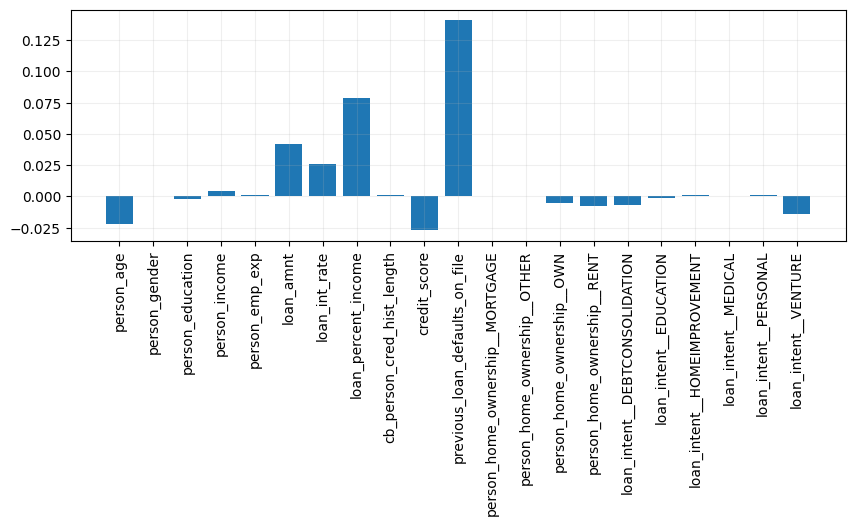

In [47]:
plt.figure(figsize=(10, 3))
plt.bar(columnas, Rx_perm_rl)
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.show()

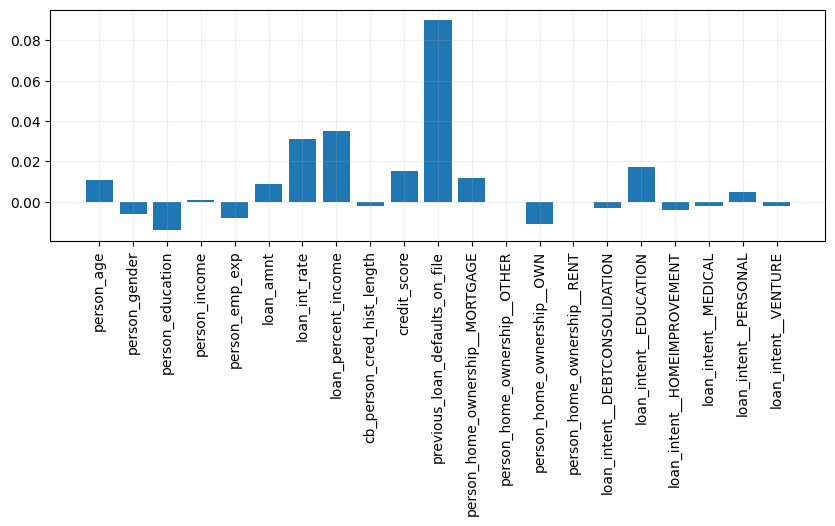

In [48]:
plt.figure(figsize=(10, 3))
plt.bar(columnas, Rx_perm_svc)
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.show()

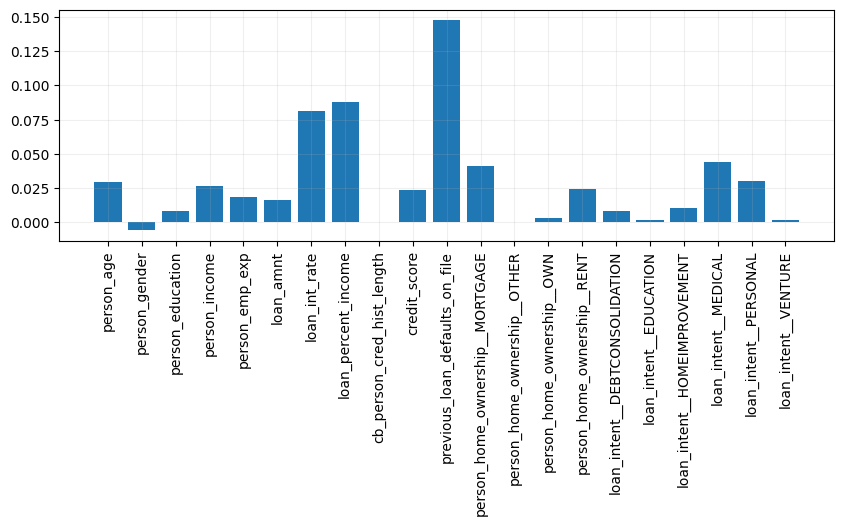

In [49]:
plt.figure(figsize=(10, 3))
plt.bar(columnas, Rx_perm_red)
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.show()

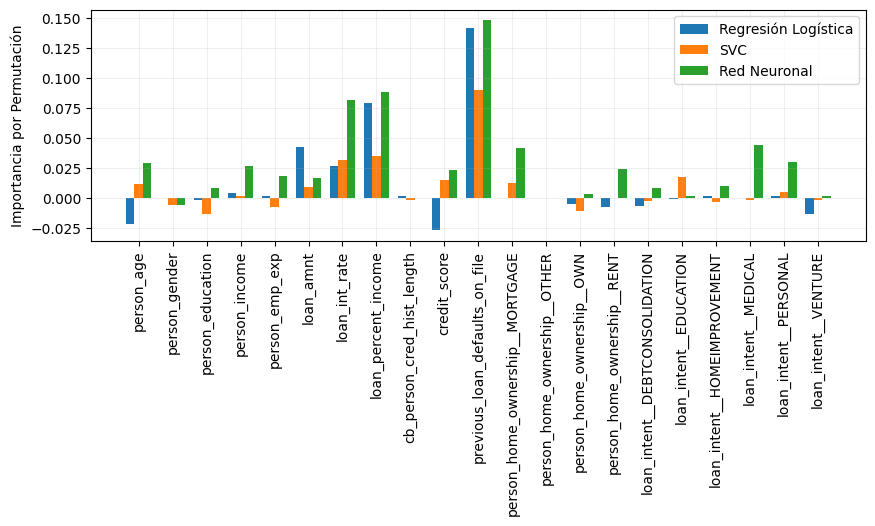

In [50]:
x = np.arange(len(columnas))
width = 0.25

plt.figure(figsize=(10, 3))
plt.bar(x - width, Rx_perm_rl, width, label="Regresión Logística")
plt.bar(x, Rx_perm_svc, width, label="SVC")
plt.bar(x + width, Rx_perm_red, width, label="Red Neuronal")
plt.xticks(x, columnas, rotation=90)
plt.ylabel("Importancia por Permutación")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**¿Conclusiones?**

Yo diría que...

- Si para 3 modelos distintos hay atributos que tienen siempre relevancia con magnitud bajita, es que esos atributos sobran en el dataset.

- Si hay algunos atributos que siempre tienen relevancia alta, ya sea por arriba o por abajo, es que son relevantes en el dataset.

- La clave está en que algunos atributos son útiles para algún modelo pero inútiles para otro. Eso significa que estás explicando el modelo en particular y no seleccionando atributos en general.

### Relevancia por oclusión [Método local y global]

La relevancia por oclusión, en general, se utiliza como técnica de explicabilidad de modelos que procesan imágenes, pero, aunque es una técnica que veremos más adelante aplicada a dicha tarea, también puede ser utilizada en problemas tabulares. La relevancia por oclusión es un método híbrido, que puede ser aplicado de forma tanto local (para una observación concreta) como global (para todo el dataset), que consiste en anular una región del espacio de atributos de entrada.

El término anular consiste en reemplazar un atributo $i$-ésimo por un valor "inteligente", por ejemplo:

- Un valor fijo 0

- La media del atributo

- La moda del atributo

- Un valor imputado mediante un algoritmo más complejo

La relevancia por oclusión global para datos tabulares se calcula, entonces, de la siguiente manera:

$$R_i = M(X) - M(X'_i)$$

donde $M(X)$ representa una métrica de rendimiento del modelo $M$ al procesar el dataset $X$ y $M(X'_i)$ representa la misma métrica de rendimiento al procesar el dataset con el atributo $i$-ésimo anulado.

Sin embargo, si se busca la oclusión a nivel local, se calcularía de la siguiente manera:

$$R_i(x) = f(x) - f(x'_i)$$

donde $f(x)$ es la predicción del modelo para el dato de entrada $x$ y $f(x'_i)$ es la predicción del mismo modelo para el dato de entrada $x$ con el atributo $i$-ésimo anulado.

**¿Por qué se sigue esta estrategia?**

Esta estrategia se basa en una idea parecida a la importancia por permutación, donde se evalúa el modelo después de modificar un atributo de entrada del dataset.

En el siguiente código se va a utilizar el valor fijo 0 porque es la media de los atributos de entrada, ya que están normalizados.

In [52]:
def relevancia_oclusion(X, y, model, verbose=True):
  if X.ndim == 1: # 1 solo dato, lo ponemos en formato matricial
    X = X[None, :]
    pred = model.predict_proba(X)
  else:
    score = model.score(X, y)

  num_atributos = X.shape[-1]

  iterador_num_atributos = tqdm(range(num_atributos)) if verbose else range(num_atributos)
  Rx = np.zeros(num_atributos)
  for i in iterador_num_atributos:
    X_null = X.copy()
    X_null[:, i] = 0
    if X.shape[0] == 1: # solo un dato, relevancia local
      Rx[i] = pred[0,y] - model.predict_proba(X_null)[0,y]
    else: # más de un dato, relevancia global
      Rx[i] = score - model.score(X_null, y)
  return Rx

**Relevancia global**

In [53]:
Rx_oclu_rl = relevancia_oclusion(X_train_small, y_train_small, rl)
Rx_oclu_svc = relevancia_oclusion(X_train_small, y_train_small, svc)
Rx_oclu_red = relevancia_oclusion(X_train_small, y_train_small, red)

100%|██████████| 21/21 [00:00<00:00, 1024.31it/s]


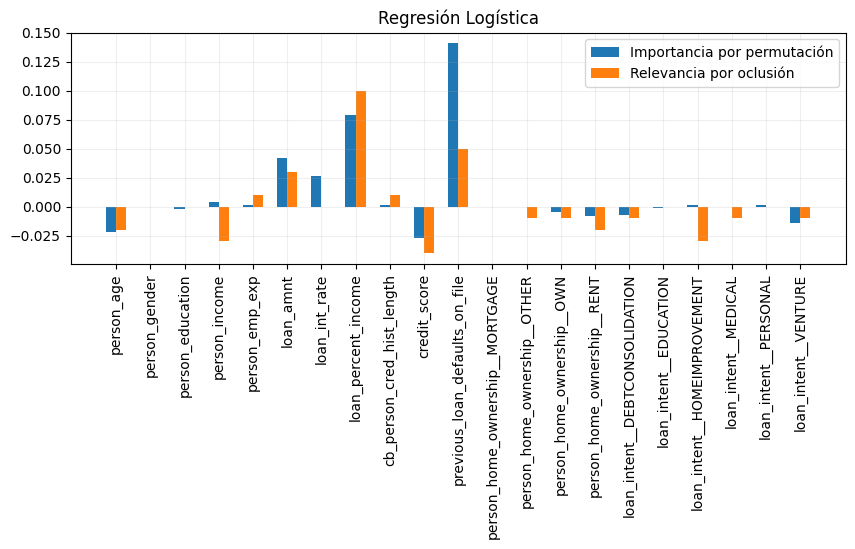

In [54]:
x = np.arange(len(columnas))
width = 0.3

plt.figure(figsize=(10, 3))
plt.bar(x - width/2, Rx_perm_rl, width, label="Importancia por permutación")
plt.bar(x + width/2, Rx_oclu_rl, width, label="Relevancia por oclusión")
plt.xticks(x, columnas, rotation=90)
plt.title("Regresión Logística")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

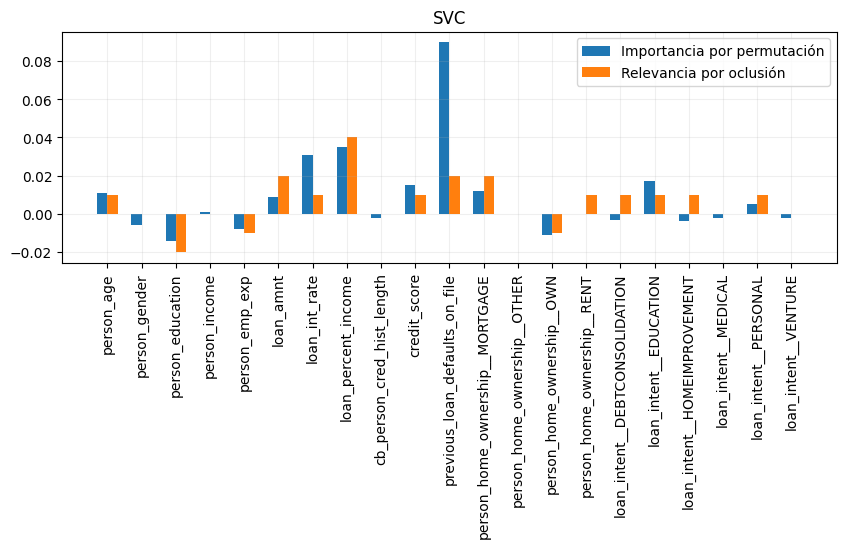

In [55]:
x = np.arange(len(columnas))
width = 0.3

plt.figure(figsize=(10, 3))
plt.bar(x - width/2, Rx_perm_svc, width, label="Importancia por permutación")
plt.bar(x + width/2, Rx_oclu_svc, width, label="Relevancia por oclusión")
plt.xticks(x, columnas, rotation=90)
plt.title("SVC")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

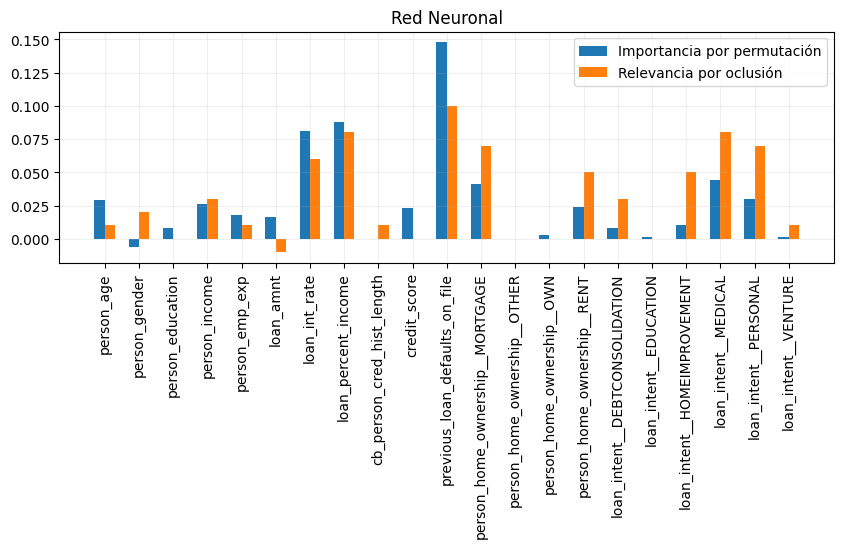

In [56]:
x = np.arange(len(columnas))
width = 0.3

plt.figure(figsize=(10, 3))
plt.bar(x - width/2, Rx_perm_red, width, label="Importancia por permutación")
plt.bar(x + width/2, Rx_oclu_red, width, label="Relevancia por oclusión")
plt.xticks(x, columnas, rotation=90)
plt.title("Red Neuronal")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

Como hemos podido ver, **dos métodos diferentes de explicabilidad dan dos resultados también diferentes**.

**Relevancia local**

Ahora vamos a explicar un dato particular.

In [57]:
item = 0

In [58]:
Rx_oclu_local_rl = relevancia_oclusion(X_train_small[item], y_train_small[item], rl)
Rx_oclu_local_svc = relevancia_oclusion(X_train_small[item], y_train_small[item], svc)
Rx_oclu_local_red = relevancia_oclusion(X_train_small[item], y_train_small[item], red)

100%|██████████| 21/21 [00:00<00:00, 2452.60it/s]


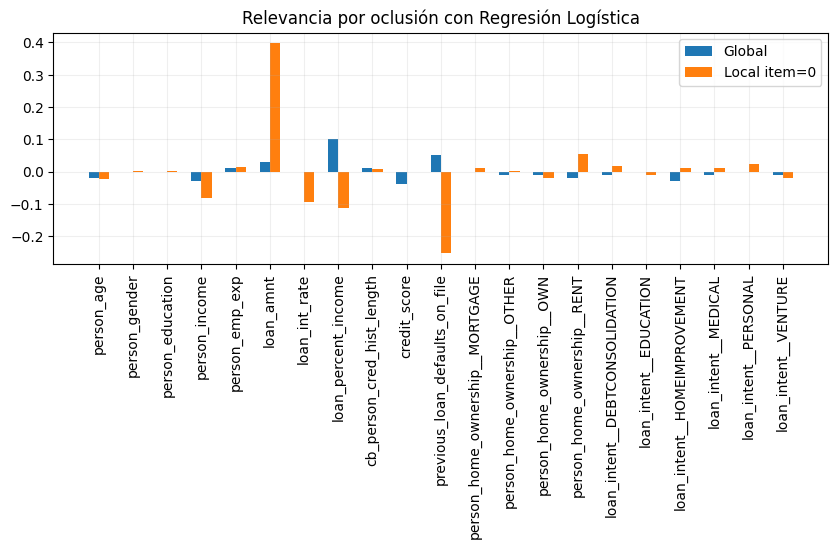

In [59]:
x = np.arange(len(columnas))
width = 0.3

plt.figure(figsize=(10, 3))
plt.bar(x - width/2, Rx_oclu_rl, width, label="Global")
plt.bar(x + width/2, Rx_oclu_local_rl, width, label="Local item="+str(item))
plt.xticks(x, columnas, rotation=90)
plt.title("Relevancia por oclusión con Regresión Logística")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

¿Por qué con el item=0 pasa que loan_percent_income, por ejemplo, es negativo?

Primero vemos el dato original y su predicción:

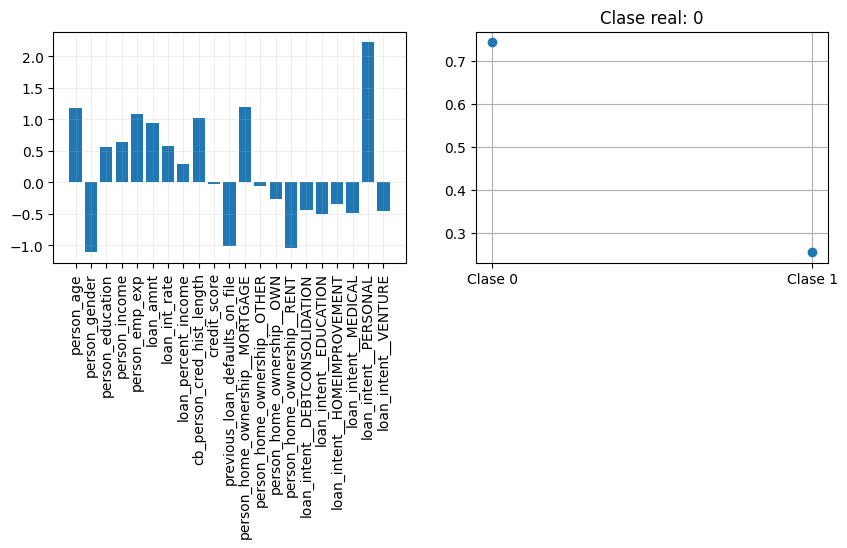

In [69]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(columnas, X_train_small[item])
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.subplot(1, 2, 2)
plt.plot([0, 1], rl.predict_proba(X_train_small[item][None, :])[0], "o")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.title("Clase real: " + str(y_train_small[item]))
plt.grid()
plt.show()

Vamos a anular **loan_percent_income**, es decir, hacerlo más pequeño.

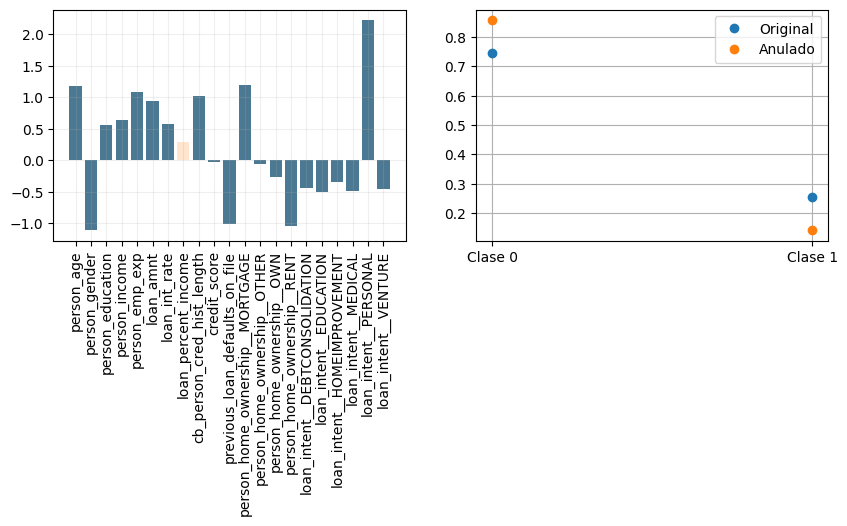

In [70]:
X_null = X_train_small[item].copy()
X_null = X_null[None, :]
X_null[:, 7] = 0

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(columnas, X_null[0])
plt.bar(columnas, X_train_small[item], alpha=0.2)
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.subplot(1, 2, 2)
plt.plot([0, 1], rl.predict_proba(X_train_small[item][None, :])[0], "o", label="Original")
plt.plot([0, 1], rl.predict_proba(X_null)[0], 'o', label="Anulado")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.grid()
plt.legend()
plt.show()

# ¿Tiene sentido?
# Si anulas un atributo cuya explicabilidad con oclusión es negativa,
# la predicción de la clase real AUMENTA

Vamos a anular ahora **loan_amnt**, es decir, bajarlo.

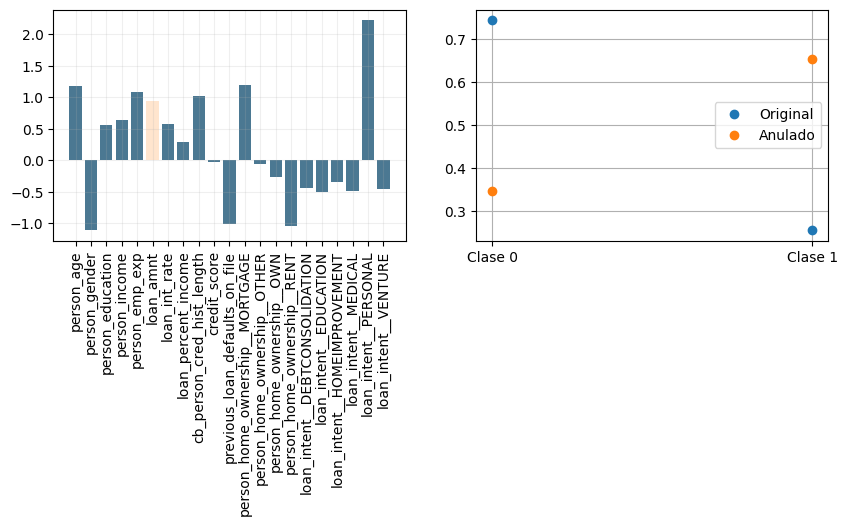

In [71]:
X_null = X_train_small[item].copy()
X_null = X_null[None, :]
X_null[:, 5] = 0

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(columnas, X_null[0])
plt.bar(columnas, X_train_small[item], alpha=0.2)
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.subplot(1, 2, 2)
plt.plot([0, 1], rl.predict_proba(X_train_small[item][None, :])[0], "o", label="Original")
plt.plot([0, 1], rl.predict_proba(X_null)[0], 'o', label="Anulado")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.grid()
plt.legend()
plt.show()

# ¿Tiene sentido?
# Si anulas un atributo cuya explicabilidad con oclusión es positiva,
# la predicción de la clase real DISMINUYE

### SHAP (SHapley Additive exPlanations)

El valor de Shapley en teoría de juegos para una característica $i$-ésima es el siguiente:

$$\phi_i(x) = \sum_{S\subseteq F\setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \{i\}}(x) - f_S(x)]$$

donde $F$ es el conjunto de todos los atributos (features) y $f_S(x)$ es la predicción del modelo cuando sólo usamos los atributos de $S$, imputando el resto. Es decir, hay que calcular todas las permutaciones posibles de todos los atributos con todos los atributos excepto el $i$-ésimo. Como esto es exponencial y no es viable, lo que se hace en la práctica es **muestrear permutaciones aleatorias de atributos**.

¿En qué consiste la idea? En ir introduciendo de forma aleatoria atributos a la instancia del dataset, imputando el resto de atributos (con la media por ejemplo) y evaluando cómo afecta incorporar ese atributo a la decisión del modelo. Podemos basarnos en esta idea:

$$contribución_i = f_{S\cup \{i\}}(x) - f_S(x)$$

SHAP es, por tanto, un método de explicabilidad local que utiliza la imputación conforme al total de los datos para explicar una instancia particular del dataset.

In [72]:
def shap(X, y, model, item, N=10, verbose=True):
    num_atributos = X.shape[1]
    shap_values = np.zeros(num_atributos)
    x = X[item][None, :]
    y = y[item]

    baseline = model.predict_proba(X).mean(axis=0, keepdims=True)

    iterador_N = tqdm(range(N)) if verbose else range(N)
    for _ in iterador_N:
      prev_pred = baseline
      perm = np.random.permutation(num_atributos)
      for c, i in enumerate(perm):
        x_S = x.copy()
        x_S[:, perm[c+1:]] = X.mean(axis=0)[perm[c+1:]] # Esta estrategia puede ser diferente
        pred = model.predict_proba(x_S)
        shap_values[i] += (pred - prev_pred)[0,y]
        prev_pred = pred

    return shap_values / N

In [74]:
Rx_shap_rl = shap(X_train_small, y_train_small, rl, item=0, N=50)

100%|██████████| 50/50 [00:00<00:00, 63.52it/s]


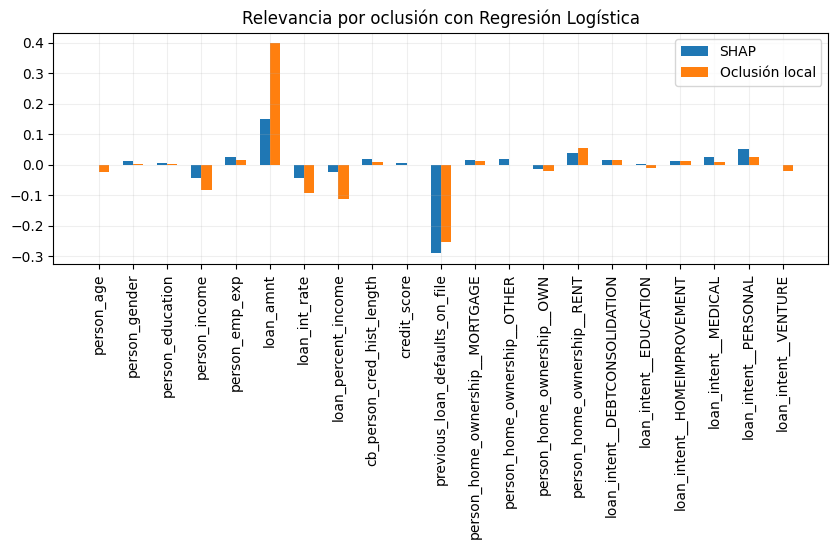

In [75]:
x = np.arange(len(columnas))
width = 0.3

plt.figure(figsize=(10, 3))
plt.bar(x - width/2, Rx_shap_rl, width, label="SHAP")
plt.bar(x + width/2, Rx_oclu_local_rl, width, label="Oclusión local")
plt.xticks(x, columnas, rotation=90)
plt.title("Relevancia por oclusión con Regresión Logística")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**Observación**: Relevancia por oclusión y SHAP dan una relevancia que se basa en la misma idea. Añadir o quitar atributos y ver la variación en la respuesta del modelo. Tiene sentido que sean resultados parecidos.

### LIME (Local Interpretable Model-agnostic Explanations)

LIME es un algoritmo de explicabilidad local basado en la idea de aproximar el comportamiento del modelo complejo con puntos cercanos a la instancia que se quiere explicar utilizando un modelo lineal.

¿Cómo funciona la idea?

1. Generamos un dataset sintético $X'$ alrededor de la instancia $x$.
2. Se calculan las predicciones del modelo complejo sobre $X'$.
3. Se asignan pesos a los puntos de $X'$ según su cercanía a la instancia $x$.
4. Se entrena un modelo lineal con los puntos de $X'$ según la cercanía.

Así, el modelo lineal aprende cómo cambian las predicciones alrededor de $x$. Además, **los pesos del modelo lineal son los valores de relevancia de cada atributo**.

LIME, al contrario que SHAP, no hace combinaciones exhaustivas, sino que solo mira el vecindario cercano a la instancia $x$.

In [76]:
def lime(X, y, model, item, D=1000):
  num_atributos = X.shape[1]
  x0 = X[item][None, :]
  y = y[item]

  # 1. Generamos dataset sintetico X_perturbed alrededor de x0
  X_perturbed = np.repeat(x0, D, axis=0)
  noise = np.random.normal(size=X_perturbed.shape) * X.std(axis=0, keepdims=True)
  X_perturbed += noise

  # 2. Se calculan las predicciones del modelo sobre X_perturbed
  y_perturbed = model.predict_proba(X_perturbed)[:, y]

  # 3. Se asignan pesos a los puntos de X_perturbed según la distancia a x0
  distances = np.linalg.norm(X_perturbed - x0, axis=1) + 1e-8
  weights = 1 / distances # más distancia, menor peso. Esta estrategia puede ser diferente

  # 4. Se entrena un modelo lineal con los puntos de X_perturbed
  linear_model = LinearRegression()
  linear_model.fit(X_perturbed, y_perturbed, sample_weight=weights) # NO OLVIDAR sample_weights
  Rx = linear_model.coef_

  return Rx

In [77]:
Rx_lime_rl = lime(X_train_small, y_train_small, rl, 0)

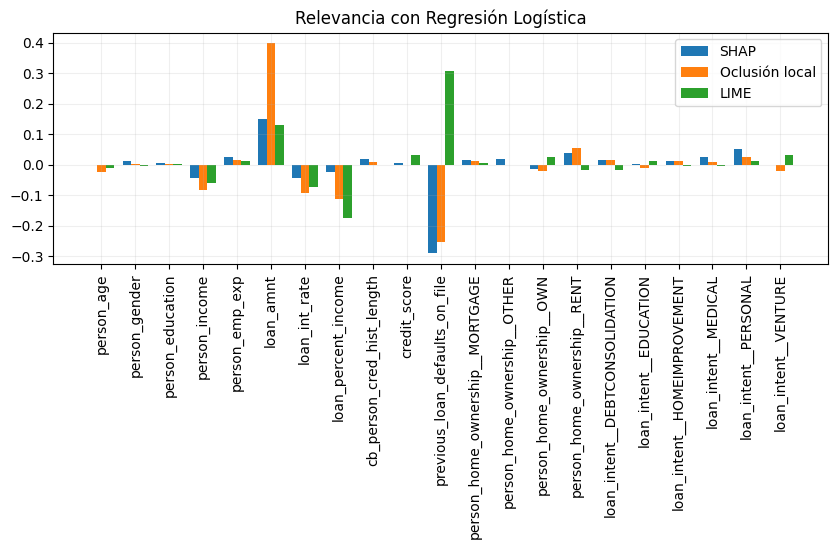

In [78]:
x = np.arange(len(columnas))
width = 0.25

plt.figure(figsize=(10, 3))
plt.bar(x - width, Rx_shap_rl, width, label="SHAP")
plt.bar(x, Rx_oclu_local_rl, width, label="Oclusión local")
plt.bar(x + width, Rx_lime_rl, width, label="LIME")
plt.xticks(x, columnas, rotation=90)
plt.title("Relevancia con Regresión Logística")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# WOW ¿Qué está pasando en LIME? previous_loan_defaults_on_file tiene el signo cambiado?

Vamos a volver a ver el dato original

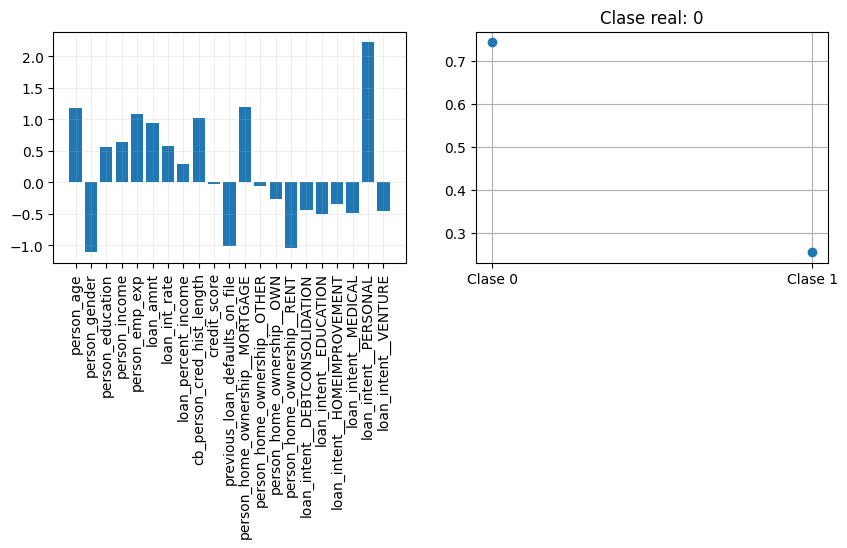

In [79]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(columnas, X_train_small[item])
plt.xticks(rotation=90)
plt.grid(alpha=0.2)
plt.subplot(1, 2, 2)
plt.plot([0, 1], rl.predict_proba(X_train_small[item][None, :])[0], "o")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.title("Clase real: " + str(y_train_small[item]))
plt.grid()
plt.show()

Fijaos la diferencia entre SHAP y Oclusión frente a LIME. ¿Cómo interpretamos las cosas? Os dejo por aquí una tabla resumen teniendo en cuenta que:

- SHAP y Oclusión **anulan atributos para definir la relevancia**
- LIME **analiza la dirección del cambio**

Por tanto:

<table>
  <tr>
    <td><b>Método</b></td>
    <td><b>Interpretación</b></td>
  </tr>
  <tr>
    <td><b>SHAP y Oclusión</b></td>
    <td>Ri > 0 --> el atributo aumenta la predicción respecto al baseline, por lo que <b>anular el atributo disminuye la predicción</b>.<br>
    Ri < 0 --> el atributo disminuye la predicción respecto al baseline, por lo que <b>anular el atributo aumenta la predicción</b>.</td>
  </tr>
  <tr>
    <td>LIME</td>
    <td>Ri > 0 --> <b>aumentar el atributo aumenta la predicción</b><br>
    Ri < 0 --> <b>aumentar el atributo disminuye la predicción</b></td>
  </tr>
</table>

**Observación IMPORTANTE**: Como los datos están normalizados, anular **no siempre significa hacer más pequeño**, sino hacerlo 0. Si yo tengo $x_i = -2$, anular es hacer $x_i = 0$ (estoy aumentando el valor del atributo).

**Observación**: ¿Puedo saber la dirección de cambio con SHAP o Oclusión? Sí, simplemente multiplicando por el signo del atributo que estás evaluando: $R_i = R_i \times sign(x_i)$. Hagámoslo con los atributos **loan_amnt** y **previous_loan_defaults_on_file**:

In [85]:
# Loan ammount
print(" > LOAN_AMNT")
print("   valor real:", X_train_small[item][5])
print("   SHAP:", Rx_shap_rl[5])
print("     que significa que si voy hacia baseline (0.0), la predicción de la clase real baja porque estoy bajando")
print("   SHAP x sign(input):", Rx_shap_rl[5] * np.sign(X_train_small[item][5]))
print("     que significa que si voy en sentido positivo, la predicción de la clase real sube")
print("   LIME:", Rx_lime_rl[5])
print("     que significa que si voy en sentido positivo, la predicción de la clase real sube")
print()

# previous_loan_defaults_on_file
print(" > previous_loan_defaults_on_file")
print("   valor real:", X_train_small[item][10])
print("   SHAP:", Rx_shap_rl[10])
print("     que significa que si voy hacia baseline (0.0), la predicción de la clase real sube porque estoy subiendo")
print("   SHAP x sign(input):", Rx_shap_rl[10] * np.sign(X_train_small[item][10]))
print("     que significa que si voy en sentido positivo, la predicción de la clase real sube")
print("   LIME:", Rx_lime_rl[10])
print("     que significa que si voy en sentido positivo, la predicción de la clase real sube")

 > LOAN_AMNT
   valor real: 0.9498298256830495
   SHAP: 0.15020338141436507
     que significa que si voy hacia baseline (0.0), la predicción de la clase real baja porque estoy bajando
   SHAP x sign(input): 0.15020338141436507
     que significa que si voy en sentido positivo, la predicción de la clase real sube
   LIME: 0.13004212373172003
     que significa que si voy en sentido positivo, la predicción de la clase real sube

 > previous_loan_defaults_on_file
   valor real: -1.0141416525247948
   SHAP: -0.28953073837451343
     que significa que si voy hacia baseline (0.0), la predicción de la clase real sube porque estoy subiendo
   SHAP x sign(input): 0.28953073837451343
     que significa que si voy en sentido positivo, la predicción de la clase real sube
   LIME: 0.3064610414415849
     que significa que si voy en sentido positivo, la predicción de la clase real sube


**¿Conclusiones? ¿Dudas?**

- El signo de **SHAP te indica lo contrario de lo que va a pasar si anulas el atributo**. Si SHAP es negativo y anulas, la predicción sube. Si SHAP es positivo y anulas, la predicción baja.

- **LIME te indica la dirección para aumentar la clase real**. Si LIME es positivo, si aumentas el atributo, la predicción sube. Si LIME es negativo, si aumentas el atributo, la predicción baja.

- Multiplicar por el signo de la instancia (`np.sign(x)`) alterna entre las dos opciones, es decir, **SHAP·signo indica la dirección para aumentar la clase real**, igual que LIME; y **LIME·signo indica lo contrario de lo que va a pasar si anulas el atributo**, igual que SHAP.

- ¿Qué método es mejor?